# Antarctic SLP trends

Author: Ziqi Yin

Last edited: Jul 29, 2025

## Description

SLP trends:
- Simulation: CESM2-LE 50 CMIP6 members; single-forcing ensembe means; O'Connor24
- Method: epoch difference of 1976:2000 minus 1901:1925
- Region: 40S-90S

In [1]:
# Load Libraries
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy.util as util
import xarray as xr
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from scipy.stats import linregress
from scipy.stats import pearsonr
import matplotlib.path as mpath
import matplotlib.colors as colors

import sys  
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')

from functions import *

import matplotlib.patches as mpatches

# For regridding
import os
import ESMF
import xesmf as xe

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
%pip install xesmf

Note: you may need to restart the kernel to use updated packages.


In [2]:
def calculate_AIS_PSL(path, fn_p1, yr_s, yr_e):

    ## Read data
    fn_PSL = fn_p1+'.PSL.'+str(yr_s)+'01-'+str(yr_e)+'12.nc'
    PSL = xr.open_dataset(path+fn_PSL).PSL

    ## Correct time
    dates = pd.date_range(str(yr_s)+'-01-01', periods=(yr_e-yr_s+1)*12, freq='M')
    PSL['time'] = dates

    # Plot period (currently same to the whole period)
    PSL_monthly = PSL.sel(time=slice(str(yr_s)+'-01-01', str(yr_e)+'-12-31')) #[Pa]
    PSL_yearly = (PSL_monthly * PSL_monthly.time.dt.days_in_month).groupby(PSL_monthly.time.dt.year).sum() /365 #[Pa]

    return PSL_yearly

## Read data

### Ensemble mean

In [3]:
## PSL
# O'Connor reconstruction (1900-2005)
path = '/glade/work/dschneid/oconnor/'

#fn_PSL_OC = 'lens_recon_psl_1900_2005_ens_mean.nc' # version 1 - O'Connor21
fn_PSL_OC = 'LENS2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom_psl.nc' # version 2 - O'Connor24
#fn_PSL_OC = 'PAC_PACE2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom_psl.nc' # version 3 - O'Connor24-TPACE
PSL_OC = xr.open_dataset(path+fn_PSL_OC).psl[:,0,:,:] #[Pa]
lat_OC = np.array(PSL_OC.lat)
lon_OC = np.array(PSL_OC.lon)

#CESM2-LE (50 cmip6 members, 1850-2100)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/CMIP6_subset/'

fn_PSL_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.cam.h0.PSL.185001-210012.nc'
PSL_LE = xr.open_dataset(path+fn_PSL_LE).PSL #[Pa]
lat = np.array(PSL_LE.lat)
lon = np.array(PSL_LE.lon)

#CESM2-AAER (20 members, 1850-2050)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/single_forcing_AAER/'

fn_PSL_AAER = 'b.e21.B1850cmip6.f09_g17.CESM2-SF-AAER.EM1-20.cam.h0.PSL.185001-205012.nc'
PSL_AAER = xr.open_dataset(path+fn_PSL_AAER).PSL

#CESM2-AAER (15 members, 1850-2050, to be consistent with CESM2-GHG)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/single_forcing_AAER/'

fn_PSL_AAER15 = 'b.e21.B1850cmip6.f09_g17.CESM2-SF-AAER.EM1-15.cam.h0.PSL.185001-205012.nc'
PSL_AAER15 = xr.open_dataset(path+fn_PSL_AAER15).PSL

#CESM2-GHG (15 members, 1850-2050)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/single_forcing_GHG/'

fn_PSL_GHG = 'b.e21.B1850cmip6.f09_g17.CESM2-SF-GHG.EM1-15.cam.h0.PSL.185001-205012.nc'
PSL_GHG = xr.open_dataset(path+fn_PSL_GHG).PSL

#CESM2-EE (15 members, 1850-2050)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/single_forcing_EE/'

fn_PSL_EE = 'b.e21.B1850cmip6.f09_g17.CESM2-SF-EE.EM1-15.cam.h0.PSL.185001-205012.nc'
PSL_EE = xr.open_dataset(path+fn_PSL_EE).PSL

#CESM2-BMB (15 members, 1850-2050)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/single_forcing_BMB/'

fn_PSL_BMB = 'b.e21.B1850cmip6.f09_g17.CESM2-SF-BMB.EM1-15.cam.h0.PSL.185001-205012.nc'
PSL_BMB = xr.open_dataset(path+fn_PSL_BMB).PSL

In [4]:
## Correct time
dates = pd.date_range("1850-01-01", periods=251*12, freq='M')
PSL_LE['time'] = dates

dates = pd.date_range("1850-01-01", periods=201*12, freq='M')
PSL_AAER['time'] = dates
PSL_AAER15['time'] = dates
PSL_GHG['time'] = dates
PSL_EE['time'] = dates
PSL_BMB['time'] = dates

/glade/derecho/scratch/ziqiyin/tmp/ipykernel_112476/266695552.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("1850-01-01", periods=251*12, freq='M')
/glade/derecho/scratch/ziqiyin/tmp/ipykernel_112476/266695552.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("1850-01-01", periods=201*12, freq='M')


In [5]:
## Select time period
PSL_LE = PSL_LE.sel(time=slice("1901-01-01", "2000-12-31"))
PSL_AAER = PSL_AAER.sel(time=slice("1901-01-01", "2000-12-31"))
PSL_AAER15 = PSL_AAER15.sel(time=slice("1901-01-01", "2000-12-31"))
PSL_GHG = PSL_GHG.sel(time=slice("1901-01-01", "2000-12-31"))
PSL_EE = PSL_EE.sel(time=slice("1901-01-01", "2000-12-31"))
PSL_BMB = PSL_BMB.sel(time=slice("1901-01-01", "2000-12-31"))

### Ensembles

In [7]:
# CESM2-LE
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/CMIP6_subset/'
yr_s = 1850
yr_e = 2100
PSL_LE_yearly = np.zeros((50, yr_e-yr_s+1, len(lat), len(lon)))
mn = ['1001.001', '1021.002', '1041.003', '1061.004', '1081.005', '1101.006', '1121.007', '1141.008', '1161.009', '1181.010',
      '1231.001', '1231.002', '1231.003', '1231.004', '1231.005', '1231.006', '1231.007', '1231.008', '1231.009', '1231.010',
      '1251.001', '1251.002', '1251.003', '1251.004', '1251.005', '1251.006', '1251.007', '1251.008', '1251.009', '1251.010',
      '1281.001', '1281.002', '1281.003', '1281.004', '1281.005', '1281.006', '1281.007', '1281.008', '1281.009', '1281.010',
      '1301.001', '1301.002', '1301.003', '1301.004', '1301.005', '1301.006', '1301.007', '1301.008', '1301.009', '1301.010']

for i in range(50):
    fn_p1 = 'b.e21.BHISTcmip6.f09_g17.LE2-'+mn[i]+'.cam.h0'
    PSL_LE_yearly[i,:,:,:] = calculate_AIS_PSL(path, fn_p1, yr_s, yr_e)

In [8]:
## Save as netcdf file
df = xr.DataArray(PSL_LE_yearly, dims=['num', 'year', 'lat', 'lon'], coords=[('num', np.arange(1,51)), ('year', np.arange(yr_s,yr_e+1)), ('lat', lat), ('lon', lon)], name='PSL', attrs=dict(longname='annual mean sea level pressure', units='Pa'))
df.to_netcdf('PSL_LEcmip6_ensemble_yearly.nc')

In [6]:
PSL_LE_ensemble_yearly = xr.open_dataset('../../PSL_LEcmip6_ensemble_yearly.nc').PSL

In [10]:
# CESM2-GHG
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/single_forcing_GHG/'
yr_s = 1850
yr_e = 2050
PSL_GHG_yearly = np.zeros((15, yr_e-yr_s+1, len(lat), len(lon)))
mn = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015']

for i in range(15):
    fn_p1 = 'b.e21.B1850cmip6.f09_g17.CESM2-SF-GHG.'+mn[i]+'.cam.h0'
    PSL_GHG_yearly[i,:,:,:] = calculate_AIS_PSL(path, fn_p1, yr_s, yr_e)

In [11]:
# Save as netcdf file
df = xr.DataArray(PSL_GHG_yearly, dims=['num', 'year', 'lat', 'lon'], coords=[('num', np.arange(1,16)), ('year', np.arange(yr_s,yr_e+1)), ('lat', lat), ('lon', lon)], name='PSL', attrs=dict(longname='annual mean sea level pressure', units='Pa'))
df.to_netcdf('PSL_GHG_ensemble_yearly.nc')

In [7]:
PSL_GHG_ensemble_yearly = xr.open_dataset('../../PSL_GHG_ensemble_yearly.nc').PSL

In [13]:
# CESM2-AAER15
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/single_forcing_AAER/'
yr_s = 1850
yr_e = 2050
PSL_AAER15_yearly = np.zeros((15, yr_e-yr_s+1, len(lat), len(lon)))
mn = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015']

for i in range(15):
    fn_p1 = 'b.e21.B1850cmip6.f09_g17.CESM2-SF-AAER.'+mn[i]+'.cam.h0'
    PSL_AAER15_yearly[i,:,:,:] = calculate_AIS_PSL(path, fn_p1, yr_s, yr_e)

In [14]:
# Save as netcdf file
df = xr.DataArray(PSL_AAER15_yearly, dims=['num', 'year', 'lat', 'lon'], coords=[('num', np.arange(1,16)), ('year', np.arange(yr_s,yr_e+1)), ('lat', lat), ('lon', lon)], name='PSL', attrs=dict(longname='annual mean sea level pressure', units='Pa'))
df.to_netcdf('PSL_AAER15_ensemble_yearly.nc')

In [8]:
PSL_AAER15_ensemble_yearly = xr.open_dataset('../../PSL_AAER15_ensemble_yearly.nc').PSL

In [10]:
# CESM2-EE
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/single_forcing_EE/'
yr_s = 1850
yr_e = 2050
PSL_EE_yearly = np.zeros((15, yr_e-yr_s+1, len(lat), len(lon)))
mn = ['101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115']

for i in range(15):
    fn_p1 = 'b.e21.B1850cmip6.f09_g17.CESM2-SF-EE.'+mn[i]+'.cam.h0'
    PSL_EE_yearly[i,:,:,:] = calculate_AIS_PSL(path, fn_p1, yr_s, yr_e)

In [12]:
# Save as netcdf file
df = xr.DataArray(PSL_EE_yearly, dims=['num', 'year', 'lat', 'lon'], coords=[('num', np.arange(1,16)), ('year', np.arange(yr_s,yr_e+1)), ('lat', lat), ('lon', lon)], name='PSL', attrs=dict(longname='annual mean sea level pressure', units='Pa'))
df.to_netcdf('PSL_EE_ensemble_yearly.nc')

In [9]:
PSL_EE_ensemble_yearly = xr.open_dataset('../../PSL_EE_ensemble_yearly.nc').PSL

## Calculate

### Ensemble mean

In [10]:
## Calculate yearly mean SMB
days_in_month = PSL_LE.time.dt.days_in_month
year = PSL_LE.time.dt.year
PSL_LE_monthly = PSL_LE #[Pa]
PSL_LE_yearly = (PSL_LE_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

PSL_AAER_monthly = PSL_AAER #[Pa]
PSL_AAER_yearly = (PSL_AAER_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

PSL_AAER15_monthly = PSL_AAER15 #[Pa]
PSL_AAER15_yearly = (PSL_AAER15_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

PSL_GHG_monthly = PSL_GHG #[Pa]
PSL_GHG_yearly = (PSL_GHG_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

PSL_EE_monthly = PSL_EE #[Pa]
PSL_EE_yearly = (PSL_EE_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

PSL_BMB_monthly = PSL_BMB #[Pa]
PSL_BMB_yearly = (PSL_BMB_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

PSL_OC_yearly = PSL_OC

In [11]:
## Calculate trend using epoch difference
PSL_LE_trend = (PSL_LE_yearly.sel(year=slice('1976','2000')).mean(dim='year') - PSL_LE_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]
PSL_AAER_trend = (PSL_AAER_yearly.sel(year=slice('1976','2000')).mean(dim='year') - PSL_AAER_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]
PSL_GHG_trend = (PSL_GHG_yearly.sel(year=slice('1976','2000')).mean(dim='year') - PSL_GHG_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]
PSL_EE_trend = (PSL_EE_yearly.sel(year=slice('1976','2000')).mean(dim='year') - PSL_EE_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]
PSL_BMB_trend = (PSL_BMB_yearly.sel(year=slice('1976','2000')).mean(dim='year') - PSL_BMB_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]
PSL_OC_trend = (PSL_OC_yearly.sel(time=slice('1976','2000')).mean(dim='time') - PSL_OC_yearly.sel(time=slice('1901','1925')).mean(dim='time')) / 75 #[Pa/yr]

# Set back nan values
PSL_LE_trend = np.where(PSL_LE_trend != 0, PSL_LE_trend, np.NaN)
PSL_AAER_trend = np.where(PSL_AAER_trend != 0, PSL_AAER_trend, np.NaN)
PSL_GHG_trend = np.where(PSL_GHG_trend != 0, PSL_GHG_trend, np.NaN)
PSL_EE_trend = np.where(PSL_EE_trend != 0, PSL_EE_trend, np.NaN)
PSL_BMB_trend = np.where(PSL_BMB_trend != 0, PSL_BMB_trend, np.NaN)
PSL_OC_trend = np.where(PSL_OC_trend != 0, PSL_OC_trend, np.NaN)

In [12]:
# Add cyclic points
PSL_LE_trend_full, lon_full = add_cyclic_point(PSL_LE_trend, coord=lon)
PSL_AAER_trend_full, lon_full = add_cyclic_point(PSL_AAER_trend, coord=lon)
PSL_GHG_trend_full, lon_full = add_cyclic_point(PSL_GHG_trend, coord=lon)
PSL_EE_trend_full, lon_full = add_cyclic_point(PSL_EE_trend, coord=lon)
PSL_BMB_trend_full, lon_full = add_cyclic_point(PSL_BMB_trend, coord=lon)
PSL_OC_trend_full, lon_OC_full = add_cyclic_point(PSL_OC_trend, coord=lon_OC)

In [13]:
# CESM2-GHG + AAER15
PSL_GHG_AAER15_ensemble_yearly = PSL_GHG_ensemble_yearly.sel(year=(slice(1901, 2000))) + PSL_AAER15_ensemble_yearly.sel(year=(slice(1901, 2000)))
PSL_GHG_AAER15_yearly = PSL_GHG_AAER15_ensemble_yearly.mean(dim='num')
PSL_GHG_AAER15_trend = (PSL_GHG_AAER15_yearly.sel(year=slice('1976','2000')).mean(dim='year') - PSL_GHG_AAER15_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]
PSL_GHG_AAER15_trend = np.where(PSL_GHG_AAER15_trend != 0, PSL_GHG_AAER15_trend, np.NaN)
PSL_GHG_AAER15_trend_full, lon_full = add_cyclic_point(PSL_GHG_AAER15_trend, coord=lon)

In [14]:
# CESM2-GHG + EE
PSL_GHG_EE_ensemble_yearly = PSL_GHG_ensemble_yearly.sel(year=(slice(1901, 2000))) + PSL_EE_ensemble_yearly.sel(year=(slice(1901, 2000)))
PSL_GHG_EE_yearly = PSL_GHG_EE_ensemble_yearly.mean(dim='num')
PSL_GHG_EE_trend = (PSL_GHG_EE_yearly.sel(year=slice('1976','2000')).mean(dim='year') - PSL_GHG_EE_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]
PSL_GHG_EE_trend = np.where(PSL_GHG_EE_trend != 0, PSL_GHG_EE_trend, np.NaN)
PSL_GHG_EE_trend_full, lon_full = add_cyclic_point(PSL_GHG_EE_trend, coord=lon)

### Ensembles

In [15]:
PSL_LE_ensemble_trend = np.zeros((50,len(lat),len(lon)))
PSL_LE_ensemble_trend_full = np.zeros((50,len(lat),len(lon)+1))

for i in range(50):
    # Calculate trend using epoch difference
    PSL_LE_ensemble_trend[i,:,:] = (PSL_LE_ensemble_yearly.sel(num=i+1).sel(year=slice('1976','2000')).mean(dim='year') - PSL_LE_ensemble_yearly.sel(num=i+1).sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]

    # Add cyclic points
    PSL_LE_ensemble_trend_full[i,:,:], lon_full = add_cyclic_point(PSL_LE_ensemble_trend[i,:,:], coord=lon)

    PSL_LE_ensemble_trend_full[i,:,:] = np.where(PSL_LE_ensemble_trend_full[i,:,:] != 0, PSL_LE_ensemble_trend_full[i,:,:], np.NaN)

### Regrid

#### xESMF, bilinear method

In [16]:
regridder_OC2f09 = xe.Regridder(PSL_OC[0,:,:], PSL_LE[0,:,:], "bilinear") # have to use the data file which contains 'lat','lon'

PSL_OC2f09_trend = regridder_OC2f09(PSL_OC_trend)

#### ESMPy, 1st order conservative method (not used)

In [17]:
# Here ESMPy is used to plot SE grids, since it seems xESMF does not support remapping to unstructred mesh now
ESMF.Manager(debug=True);

In [18]:
# Scrip files (contains grid information)
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)

In [19]:
## Generate coordinate info
# f09
f09_lons = np.tile(lon, (192, 1)).T
f09_lats = np.tile(lat, (288, 1))
f09_centers = np.stack((f09_lons, f09_lats))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

# OC21
OC_lons = np.tile(lon_OC, (181, 1)).T
OC_lats = np.tile(lat_OC, (360, 1))
OC_centers = np.stack((OC_lons, OC_lats))

OC_lon_corner = lon_OC[:] - 0.5
OC_lon_corner = np.append(OC_lon_corner, lon_OC[-1]+0.5)
OC_lon_corners = np.tile(OC_lon_corner, (182, 1)).T
OC_lat_corner = lat_OC - 0.5
OC_lat_corner = np.append(OC_lat_corner, lat_OC[-1])
OC_lat_corner[0] += 0.5
OC_lat_corners = np.tile(OC_lat_corner, (361, 1))
OC_corners = np.stack((OC_lon_corners, OC_lat_corners))

In [20]:
def regrid_con_grid_to_grid(centers_gridin, corners_gridin, precip_gridin, centers_gridout, corners_gridout): 

    gridin = ESMF.Grid(np.array(precip_gridin.T.shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridin_lon = gridin.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridin_lat = gridin.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridin_lon[...] = centers_gridin[0]
    gridin_lat[...] = centers_gridin[1]
    gridin_lon_cor = gridin.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridin_lat_cor = gridin.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridin_lon_cor[...] = corners_gridin[0]
    gridin_lat_cor[...] = corners_gridin[1]
    srcfield = ESMF.Field(gridin)
    srcfield.data[:] = precip_gridin.T #kg m-2 s-1

    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

## Correlation with reanalysis

In [17]:
# OC
PSL_OC2f09_trend_flat = PSL_OC2f09_trend[:54,:].flatten() # Select lat range and flatten

# CESM2-LE ensemble mean
PSL_LE_trend_flat = PSL_LE_trend[:54,:].flatten()
PSL_LE_trend_cor, _ = pearsonr(PSL_OC2f09_trend_flat, PSL_LE_trend_flat)

# CESM2-AAER ensemble mean
PSL_AAER_trend_flat = PSL_AAER_trend[:54,:].flatten()
PSL_AAER_trend_cor, _ = pearsonr(PSL_OC2f09_trend_flat, PSL_AAER_trend_flat)

# CESM2-GHG ensemble mean
PSL_GHG_trend_flat = PSL_GHG_trend[:54,:].flatten()
PSL_GHG_trend_cor, _ = pearsonr(PSL_OC2f09_trend_flat, PSL_GHG_trend_flat)

# CESM2-EE ensemble mean
PSL_EE_trend_flat = PSL_EE_trend[:54,:].flatten()
PSL_EE_trend_cor, _ = pearsonr(PSL_OC2f09_trend_flat, PSL_EE_trend_flat)

# CESM2-BMB ensemble mean
PSL_BMB_trend_flat = PSL_BMB_trend[:54,:].flatten()
PSL_BMB_trend_cor, _ = pearsonr(PSL_OC2f09_trend_flat, PSL_BMB_trend_flat)

In [18]:
# CESM2-GHG + CESM2-AAER15 ensemble mean
PSL_GHG_AAER15_trend_flat = PSL_GHG_AAER15_trend[:54,:].flatten()
PSL_GHG_AAER15_trend_cor, _ = pearsonr(PSL_OC2f09_trend_flat, PSL_GHG_AAER15_trend_flat)
print(PSL_GHG_AAER15_trend_cor)

0.7135011962782687


In [19]:
# CESM2-GHG + CESM2-EE ensemble mean
PSL_GHG_EE_trend_flat = PSL_GHG_EE_trend[:54,:].flatten()
PSL_GHG_EE_trend_cor, _ = pearsonr(PSL_OC2f09_trend_flat, PSL_GHG_EE_trend_flat)
print(PSL_GHG_EE_trend_cor)

0.8079045372425647


In [20]:
# CESM2-LEcmip6 ensemble members
PSL_LE_ensemble_trend_cor = np.zeros(50)

for i in range(50):
    PSL_LE_ensemble_trend_flat = PSL_LE_ensemble_trend[i,:54,:].flatten()
    PSL_LE_ensemble_trend_cor[i], _ = pearsonr(PSL_OC2f09_trend_flat, PSL_LE_ensemble_trend_flat)

## Plot

### Ensembles

#### version2 - O'Connor24

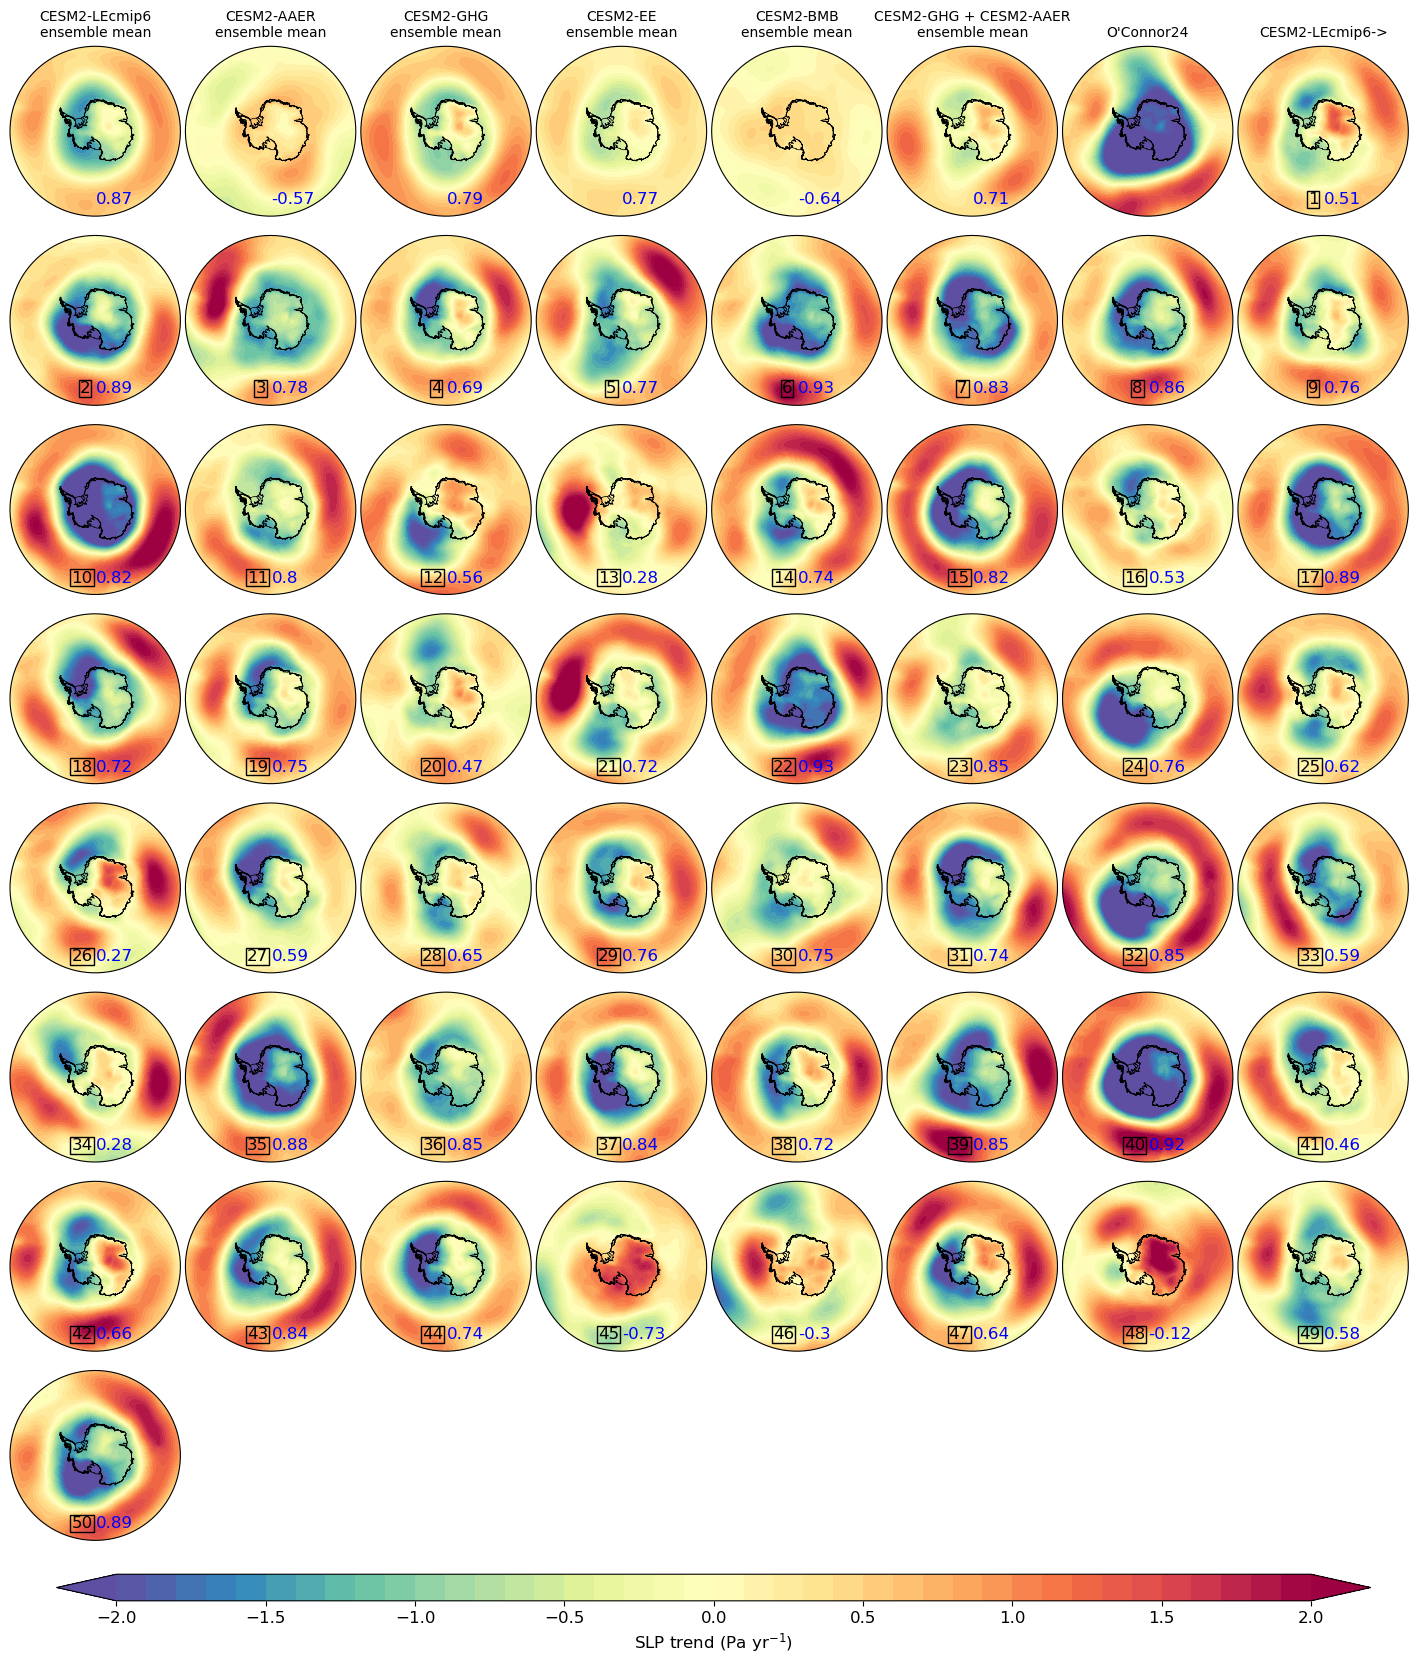

In [29]:
fig=plt.figure(figsize=(18,19))
gs=GridSpec(8,8)
plt.rcParams['axes.titlepad']=14

level_PSL = np.arange(-2., 2.01, 0.1)
ticks_PSL = np.arange(-2., 2.01, 0.5)

size_title = 10
size_label = 12
size_tick = 12
size_text = 12

cmap1='Spectral_r'

######################### Esemble mean #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -40)

im1=ax1.contourf(lon_full, lat, PSL_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax1.set_title('CESM2-LEcmip6\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax1.text(50000, -5200000, round(PSL_LE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-AAER 20 members
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -40)

im2=ax2.contourf(lon_full, lat, PSL_AAER_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax2.set_title('CESM2-AAER\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax2.text(50000, -5200000, round(PSL_AAER_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-GHG
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -40)

im3=ax3.contourf(lon_full, lat, PSL_GHG_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax3.set_title('CESM2-GHG\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax3.text(50000, -5200000, round(PSL_GHG_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-EE
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -40)

im4=ax4.contourf(lon_full, lat, PSL_EE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax4.set_title('CESM2-EE\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax4.text(50000, -5200000, round(PSL_EE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-BMB
ax5 = plt.subplot(gs[4], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax5, -40)

im5=ax5.contourf(lon_full, lat, PSL_BMB_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax5.set_title('CESM2-BMB\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax5.text(50000, -5200000, round(PSL_BMB_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-GHG + AAER15
ax6 = plt.subplot(gs[5], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax6, -40)

im6=ax6.contourf(lon_full, lat, PSL_GHG_AAER15_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax6.set_title('CESM2-GHG + CESM2-AAER\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax6.text(50000, -5200000, round(PSL_GHG_AAER15_trend_cor, 2), fontsize=size_text, color='b')

# O'Connor
ax7 = plt.subplot(gs[6], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax7, -40)

im7=ax7.contourf(lon_OC_full, lat_OC, PSL_OC_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax7.set_title('O\'Connor24', pad=8, fontsize=size_title)


######################### Esemble members #########################
for i in range(50):
    ax = plt.subplot(gs[i+7], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_LE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LEcmip6->', pad=8, fontsize=size_title)
        ax.text(-1100000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1700000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -5200000, round(PSL_LE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.014]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_PSL, ticks=ticks_PSL)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('SLP trend (Pa yr$^{-1}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.07)

plt.subplots_adjust(bottom=0.09)
plt.savefig('map_AIS_PSL_trend_CESM2-LEcmip6_single-forcing_ensemble_OC24_epoch.jpg', dpi=300)
#plt.show()

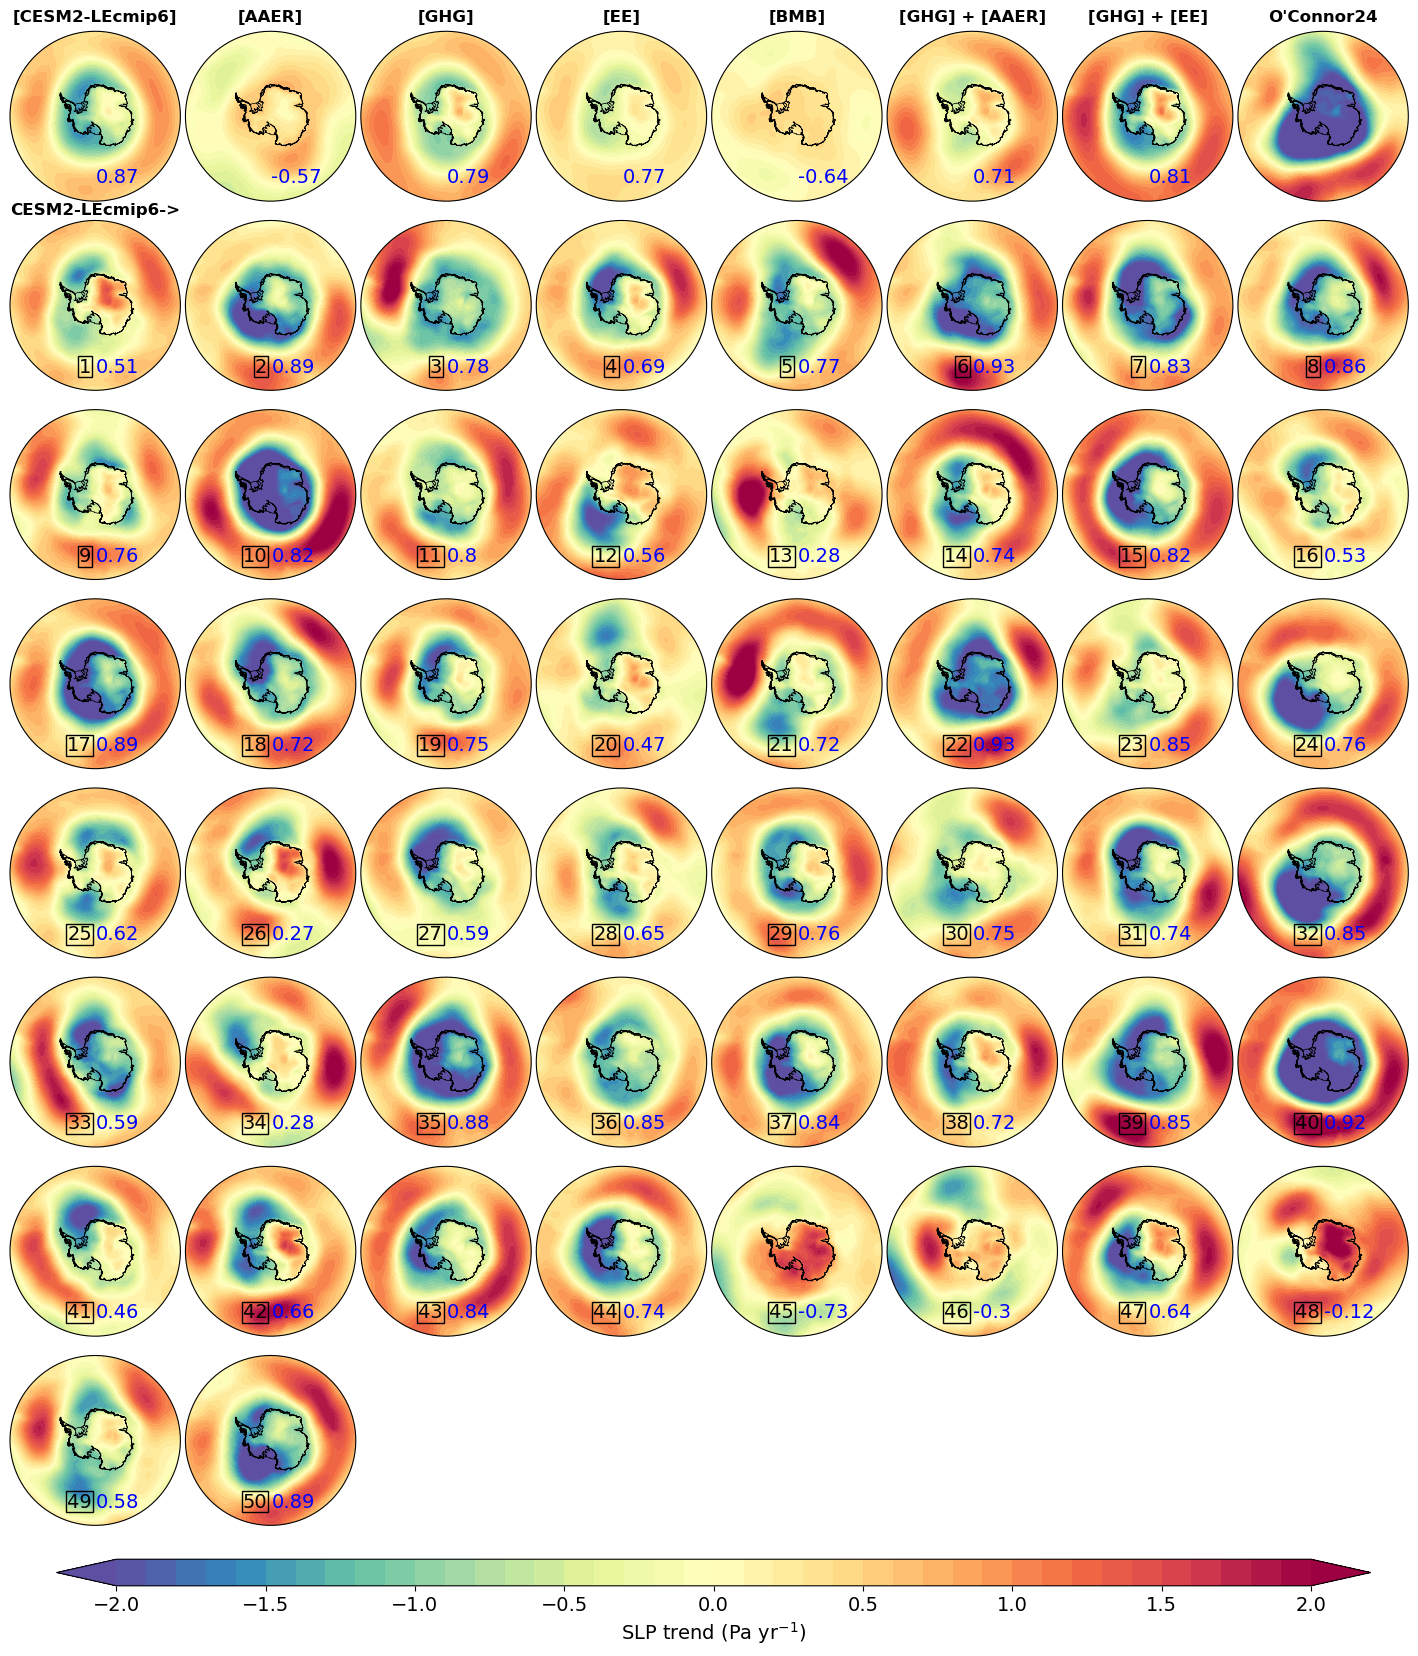

In [21]:
fig=plt.figure(figsize=(18,19))
gs=GridSpec(8,8)
plt.rcParams['axes.titlepad']=14

level_PSL = np.arange(-2., 2.01, 0.1)
ticks_PSL = np.arange(-2., 2.01, 0.5)

size_title = 10+2
size_label = 12+2
size_tick = 12+2
size_text = 12+2

cmap1='Spectral_r'

######################### Esemble mean #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -40)

im1=ax1.contourf(lon_full, lat, PSL_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax1.set_title('[CESM2-LEcmip6]', pad=8, fontsize=size_title, fontweight='bold')
ax1.text(50000, -4800000, round(PSL_LE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-AAER 20 members
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -40)

im2=ax2.contourf(lon_full, lat, PSL_AAER_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax2.set_title('[AAER]', pad=8, fontsize=size_title, fontweight='bold')
ax2.text(50000, -4800000, round(PSL_AAER_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-GHG
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -40)

im3=ax3.contourf(lon_full, lat, PSL_GHG_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax3.set_title('[GHG]', pad=8, fontsize=size_title, fontweight='bold')
ax3.text(50000, -4800000, round(PSL_GHG_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-EE
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -40)

im4=ax4.contourf(lon_full, lat, PSL_EE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax4.set_title('[EE]', pad=8, fontsize=size_title, fontweight='bold')
ax4.text(50000, -4800000, round(PSL_EE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-BMB
ax5 = plt.subplot(gs[4], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax5, -40)

im5=ax5.contourf(lon_full, lat, PSL_BMB_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax5.set_title('[BMB]', pad=8, fontsize=size_title, fontweight='bold')
ax5.text(50000, -4800000, round(PSL_BMB_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-GHG + AAER15
ax6 = plt.subplot(gs[5], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax6, -40)

im6=ax6.contourf(lon_full, lat, PSL_GHG_AAER15_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax6.set_title('[GHG] + [AAER]', pad=8, fontsize=size_title, fontweight='bold')
ax6.text(50000, -4800000, round(PSL_GHG_AAER15_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-GHG + EE
ax7 = plt.subplot(gs[6], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax7, -40)

im7=ax7.contourf(lon_full, lat, PSL_GHG_EE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax7.set_title('[GHG] + [EE]', pad=8, fontsize=size_title, fontweight='bold')
ax7.text(50000, -4800000, round(PSL_GHG_EE_trend_cor, 2), fontsize=size_text, color='b')

# O'Connor
ax8 = plt.subplot(gs[7], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax8, -40)

im8=ax8.contourf(lon_OC_full, lat_OC, PSL_OC_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax8.set_title('O\'Connor24', pad=8, fontsize=size_title, fontweight='bold')


######################### Esemble members #########################
for i in range(50):
    ax = plt.subplot(gs[i+8], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_LE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LEcmip6->', pad=5, fontsize=size_title, fontweight='bold')
        ax.text(-1150000, -4800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-2000000, -4800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -4800000, round(PSL_LE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.014]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_PSL, ticks=ticks_PSL)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('SLP trend (Pa yr$^{-1}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.07)

plt.subplots_adjust(bottom=0.09)
plt.savefig('../plot/C4_map_AIS_PSL_trend_CESM2-LEcmip6_single-forcing_ensemble_OC24_epoch_2501.jpg',
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)
#plt.show()

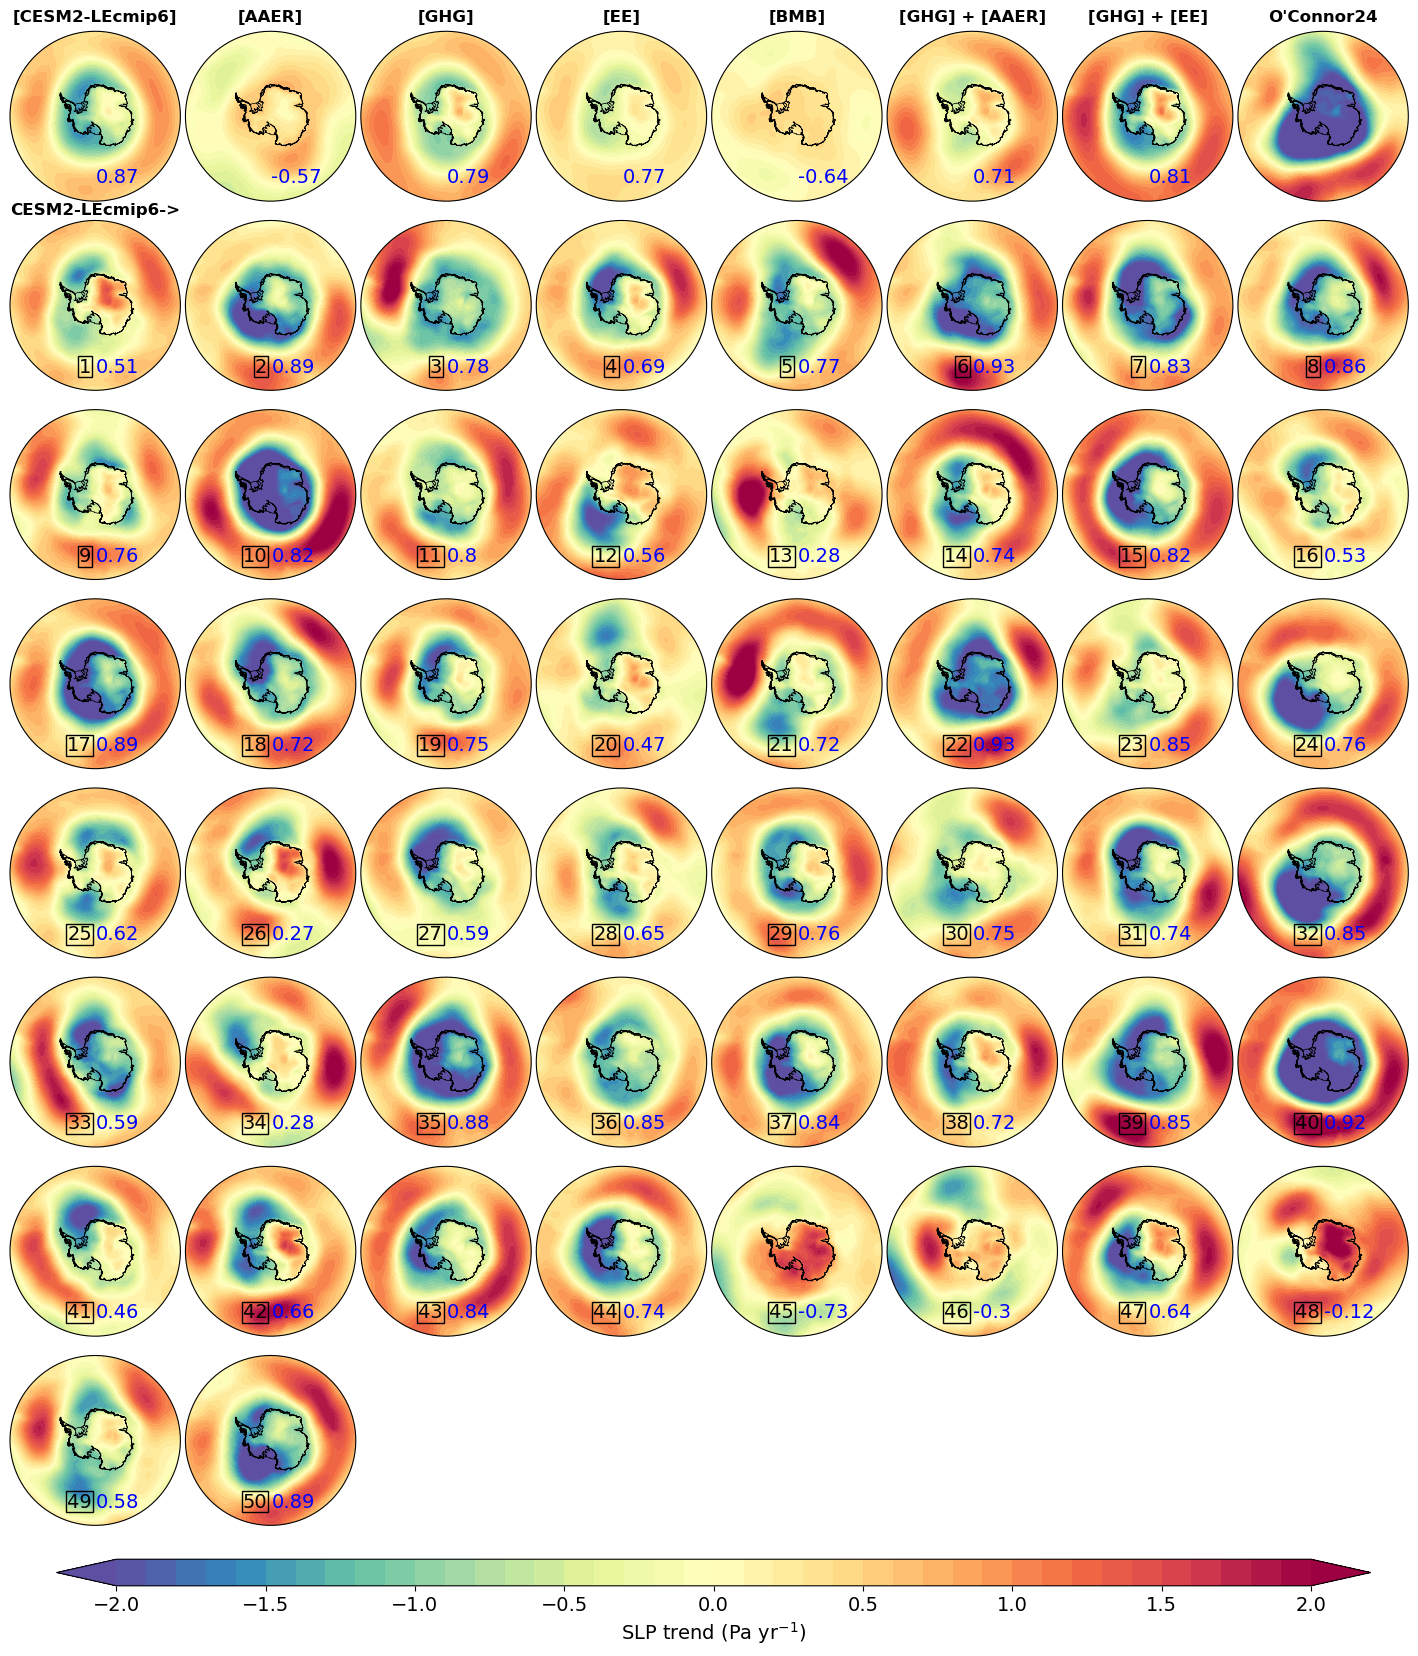

In [22]:
# Save as pdf format
fig=plt.figure(figsize=(18,19))
gs=GridSpec(8,8)
plt.rcParams['axes.titlepad']=14

level_PSL = np.arange(-2., 2.01, 0.1)
ticks_PSL = np.arange(-2., 2.01, 0.5)

size_title = 10+2
size_label = 12+2
size_tick = 12+2
size_text = 12+2

cmap1='Spectral_r'

######################### Esemble mean #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -40)

im1=ax1.contourf(lon_full, lat, PSL_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax1.set_title('[CESM2-LEcmip6]', pad=8, fontsize=size_title, fontweight='bold')
ax1.text(50000, -4800000, round(PSL_LE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-AAER 20 members
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -40)

im2=ax2.contourf(lon_full, lat, PSL_AAER_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax2.set_title('[AAER]', pad=8, fontsize=size_title, fontweight='bold')
ax2.text(50000, -4800000, round(PSL_AAER_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-GHG
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -40)

im3=ax3.contourf(lon_full, lat, PSL_GHG_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax3.set_title('[GHG]', pad=8, fontsize=size_title, fontweight='bold')
ax3.text(50000, -4800000, round(PSL_GHG_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-EE
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -40)

im4=ax4.contourf(lon_full, lat, PSL_EE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax4.set_title('[EE]', pad=8, fontsize=size_title, fontweight='bold')
ax4.text(50000, -4800000, round(PSL_EE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-BMB
ax5 = plt.subplot(gs[4], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax5, -40)

im5=ax5.contourf(lon_full, lat, PSL_BMB_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax5.set_title('[BMB]', pad=8, fontsize=size_title, fontweight='bold')
ax5.text(50000, -4800000, round(PSL_BMB_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-GHG + AAER15
ax6 = plt.subplot(gs[5], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax6, -40)

im6=ax6.contourf(lon_full, lat, PSL_GHG_AAER15_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax6.set_title('[GHG] + [AAER]', pad=8, fontsize=size_title, fontweight='bold')
ax6.text(50000, -4800000, round(PSL_GHG_AAER15_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-GHG + EE
ax7 = plt.subplot(gs[6], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax7, -40)

im7=ax7.contourf(lon_full, lat, PSL_GHG_EE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax7.set_title('[GHG] + [EE]', pad=8, fontsize=size_title, fontweight='bold')
ax7.text(50000, -4800000, round(PSL_GHG_EE_trend_cor, 2), fontsize=size_text, color='b')

# O'Connor
ax8 = plt.subplot(gs[7], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax8, -40)

im8=ax8.contourf(lon_OC_full, lat_OC, PSL_OC_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax8.set_title('O\'Connor24', pad=8, fontsize=size_title, fontweight='bold')


######################### Esemble members #########################
for i in range(50):
    ax = plt.subplot(gs[i+8], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_LE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LEcmip6->', pad=5, fontsize=size_title, fontweight='bold')
        ax.text(-1150000, -4800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-2000000, -4800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -4800000, round(PSL_LE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.014]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_PSL, ticks=ticks_PSL)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('SLP trend (Pa yr$^{-1}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.07)

plt.subplots_adjust(bottom=0.09)
plt.savefig(
    '../plot/C4_map_AIS_PSL_trend_CESM2-LEcmip6_single-forcing_ensemble_OC24_epoch_2501.pdf',
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)